In [ ]:
!pip install clearml
!pip3 install -U scikit-learn
!pip install catboost
!pip install seaborn
!pip install matplotlib

In [1]:
%env CLEARML_WEB_HOST=https://app.clear.ml
%env CLEARML_API_HOST=https://api.clear.ml
%env CLEARML_FILES_HOST=https://files.clear.ml
%env CLEARML_API_ACCESS_KEY=07L8L9156DBREROKNQQN
%env CLEARML_API_SECRET_KEY=5pb9e86DV4PB0pXm65YYm8NvqvwEeyNFWc6OFZGUxa0brZfhGc

env: CLEARML_WEB_HOST=https://app.clear.ml
env: CLEARML_API_HOST=https://api.clear.ml
env: CLEARML_FILES_HOST=https://files.clear.ml
env: CLEARML_API_ACCESS_KEY=07L8L9156DBREROKNQQN
env: CLEARML_API_SECRET_KEY=5pb9e86DV4PB0pXm65YYm8NvqvwEeyNFWc6OFZGUxa0brZfhGc


In [2]:
import pandas as pd
import numpy as np
from clearml import Task, Logger
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, ParameterSampler
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import roc_auc_score 

In [5]:
task = Task.init(
    project_name='lab3', 
    task_name='task1', 
    tags=['CatBoost','RandomSearch'])

In [11]:
#prev_task = Task.get_task(task_id='ae92b12f332549ce8bc55d56baa23370')

In [6]:
fpath = "./data/cars.csv"
df_raw = pd.read_csv(fpath, delimiter=';').iloc[1:]
task.upload_artifact(name='data.raw', artifact_object=fpath)

True

In [7]:
for col in df_raw.columns[1:-1]:
    df_raw[col] = df_raw[col].astype(np.float32)
df_raw.head(5)

,Car,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model,Origin
1,Chevrolet Chevelle Malibu,18.0,8.0,307.0,130.0,3504.0,12.0,70.0,US
2,Buick Skylark 320,15.0,8.0,350.0,165.0,3693.0,11.5,70.0,US
3,Plymouth Satellite,18.0,8.0,318.0,150.0,3436.0,11.0,70.0,US
4,AMC Rebel SST,16.0,8.0,304.0,150.0,3433.0,12.0,70.0,US
5,Ford Torino,17.0,8.0,302.0,140.0,3449.0,10.5,70.0,US


In [8]:
task.upload_artifact(
    name='eda.describe.object', 
    artifact_object=df_raw.describe(include=object))
task.upload_artifact(
    name='eda.describe.number', 
    artifact_object=df_raw.describe(include=np.number))

True

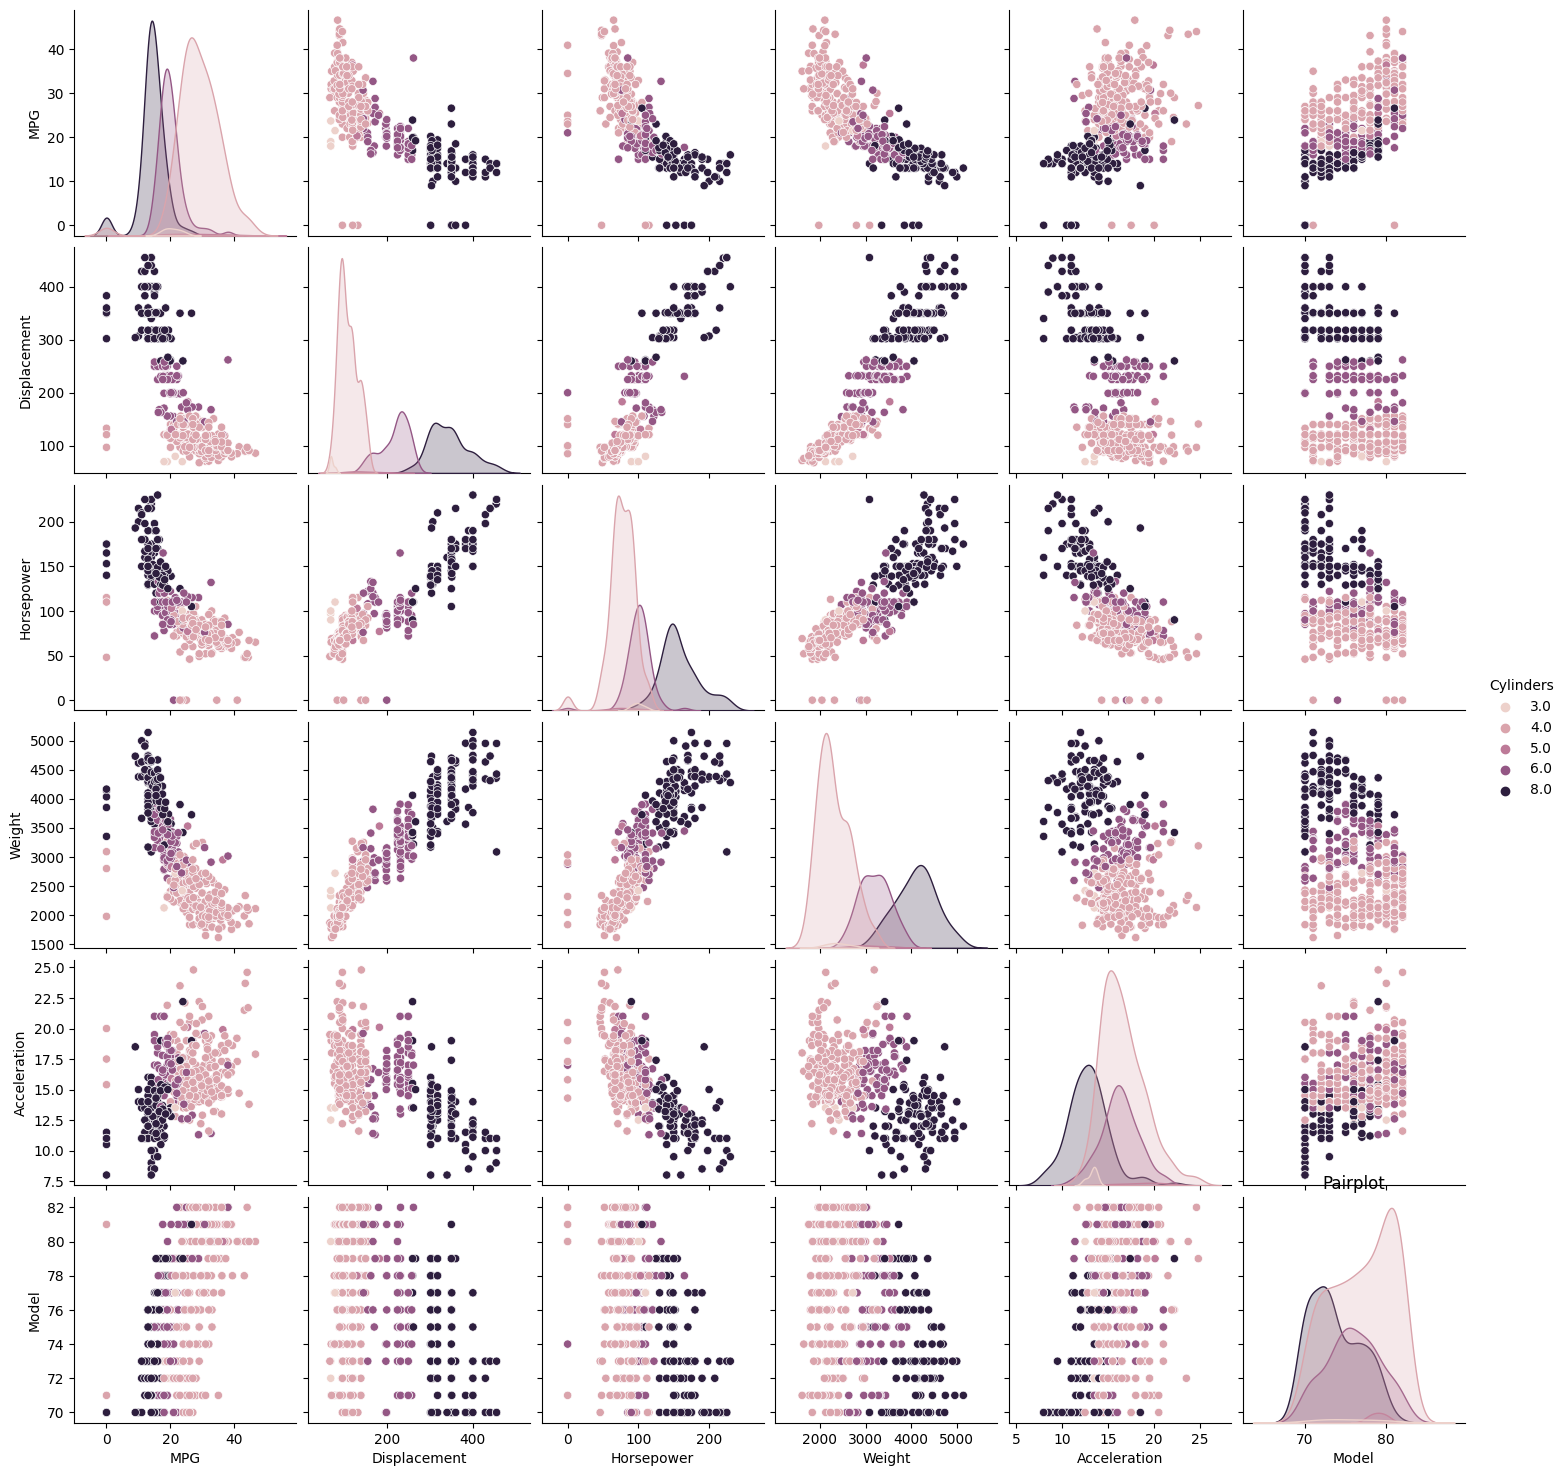

In [9]:
sns.pairplot(df_raw, hue='Cylinders')
plt.title('Pairplot')
plt.show()

In [10]:
df_preproc = df_raw.drop(columns=['Car'])
for col in ['Origin']:
    df_preproc[col] = df_preproc[col].astype(str)
task.upload_artifact(name='data.preproc', artifact_object=df_preproc)

train, test = train_test_split(df_preproc, test_size=0.33, random_state=42)
task.upload_artifact(name='data.train', artifact_object=train)
task.upload_artifact(name='data.test', artifact_object=test)

True

In [11]:
# dict with hyperparameters
param_grid = {
    'depth': [4,5,6,7,8],
    'learning_rate': [0.1,0.05,0.01,0.005,0.001],
    'iterations': [30,50,100,150]
}

# train dataset
X_train = train.drop(columns=['Cylinders'])
y_train = train['Cylinders']


# test dataset
X_test = test.drop(columns=['Cylinders'])
y_test = test['Cylinders']

# logger init
log = Logger.current_logger()

# best scores init
best_score = 25
best_model = None
i = 0

# loop over random 50 hyperparameters
for param in ParameterSampler(param_grid, n_iter=50, random_state=42):
    # Обучаем модель
    model = CatBoostClassifier(**param, silent=True)
    model.fit(X_train, y_train, cat_features=['Origin'])

    # Оцениваем модель
    test_scores = model.eval_metrics(
        data=Pool(X_test, y_test, cat_features=['Origin']),
        metrics=['TotalF1','HingeLoss'])
    test_f1  = round(test_scores['TotalF1'][-1], 4)
    test_hinge_loss = round(test_scores['HingeLoss'][-1]*100, 1)
    
    train_scores = model.eval_metrics(
        data=Pool(X_train, y_train, cat_features=['Origin']),
        metrics=['TotalF1','HingeLoss'])
    train_f1  = round(train_scores['TotalF1'][-1], 4)
    train_hinge_loss = round(train_scores['HingeLoss'][-1]*100, 1)

    # comparision with best score
    if test_hinge_loss < best_score:
        # save model
        best_score = test_hinge_loss
        best_model = model

        # write metrics to ClearML
        log.report_scalar("TotalF1", "Test", iteration=i, value=test_f1)
        log.report_scalar("TotalF1", "Train", iteration=i, value=train_f1)
        
        log.report_scalar("HingeLoss", "Test", iteration=i, value=test_hinge_loss)
        log.report_scalar("HingeLoss", "Train", iteration=i, value=train_hinge_loss)
        
        i+=1

In [12]:
log.report_single_value(name='Best HingeLoss', value=test_hinge_loss)
log.report_single_value(name='Best TotalF1', value=train_f1)
log.report_single_value(name='Train Rows', value=X_train.shape[0])
log.report_single_value(name='Test Rows', value=X_test.shape[0])
log.report_single_value(name='Columns', value=X_train.shape[1])
log.report_single_value(name='Train Ratio', value=round(y_train.mean(),3))
log.report_single_value(name='Test Ratio', value=round(y_test.mean(),3))

In [13]:
best_model.save_model('my_model.cbm')
task.close()